In [1]:
import torch
import numpy as np
from se3_transformer_pytorch import SE3Transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import ase.io
from collections import defaultdict, namedtuple
import torch.autograd as auto
from math import sqrt
from itertools import product
import sys
sys.path.append("./se3_trans")
import torch
import mendeleev

torch.set_default_dtype(torch.float64) # works best in float64?
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output


# %matplotlib widget

In [2]:
def get_gpaw_trajectories(defect_db_path:str):
    res = defaultdict(list)
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
                res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return res


data_raw = get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [17]:
_data_processed = {}
for key, defect_vars in data_raw.items():
    energies = []
    coordinates = []
    forces = []
    atoms = []
    for traj in defect_vars:
        energies.append(np.array([a.get_potential_energy() for a in traj], dtype=np.float64))
        coordinates.append(np.array([a.positions for a in traj], dtype=np.float64))
        forces.append(np.array([a.get_forces() for a in traj], dtype=np.float64))

    try:
        _data_processed[key] = (np.concatenate(energies), np.concatenate(coordinates), np.concatenate(forces))
    except ValueError:
        print('Empty list')


In [20]:
data = {}
for k, v in _data_processed.items():
    en, cord, f = v
    en = (en - np.mean(en)) / np.std(en)
    cord = (cord - np.mean(cord)) / np.std(cord)
    f = (f - np.mean(f)) / np.std(f)
    data[k] = (en, cord, f)

In [23]:
class Dataset(Dataset):

    def __init__(self, data, train=True, transform=None):
        self.data = data
        self.energies_train, self.energies_test, \
        self.coordinates_train, self.coordinates_test, \
        self.forces_train, self.forces_test = train_test_split(*self.data['id24'], test_size=0.25, random_state=666)
    
        self.energies, self.coordinates, self.forces = self.data['id24']
        if train:
            self.coordinates = self.coordinates_train
            self.energies = self.energies_train
            self.forces = self.forces_train
        else:
            self.coordinates = self.coordinates_test
            self.energies = self.energies_test
            self.forces = self.forces_test

    def __len__(self):
        return self.coordinates.shape[0]

    def __getitem__(self, idx):
        return ((self.coordinates[idx], self.energies[idx], self.forces[idx]),
                (self.coordinates[-1], self.energies[-1], self.forces[-1]))
                
      

dataset = Dataset(data)
dataloader = DataLoader(dataset, batch_size=2,
                        shuffle=True, num_workers=0)



In [24]:
from se3_transformer_pytorch import SE3Transformer
from se3_transformer_pytorch.se3_transformer_pytorch import FeedForwardSE3
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.IS2RS = SE3Transformer(
            dim = 3,
            heads = 4,
            depth = 4,
            dim_head = 8,
            num_degrees = 2,
            valid_radius = 5,
            reduce_dim_out = False,
            causal = False
        )
#         self.S2EF = SE3Transformer(
#             dim = 3,
#             heads = 4,
#             depth = 4,
#             dim_head = 8,
#             num_degrees = 2,
#             valid_radius = 5,
#             reduce_dim_out = False,
#             causal = False
#         )
        
        
        self.lin_1 = nn.Linear(75, 32)
        self.lin_2 = nn.Linear(32, 1)
    
    def forward(self, cord, feat, mask):
        rs = self.IS2RS(cord, feat, mask)
#         rs_em = self.S2EF(cord, feat, mask)
#         out = F.relu(self.lin_1(out_se3))
#         out = self.lin_2(out)
        return rs
        

feats = torch.randn(1, 75, 3)
coors = torch.rand(1, 75, 3)#torch.Size([261, 75, 3])
mask  = torch.ones(1, 75).bool()
model = Model()
out = model(feats, coors, mask) # (1, 1024, 512)

In [25]:
model = Model()
model = model.cuda()

# state_dict = torch.load('checkpoints/checkpoint__deg4_64300.pth')
# model.state_dict(state_dict['model_state_dict'])
# print()

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=0)
# scheduler = get_cosine_schedule_with_warmup(optimizer, 500, 5000)


force_coefficient = 0.5
losses_en = [0]
losses_f = [0]
losses_coord = [0]

loader = iter(dataloader)
model.train()
print()


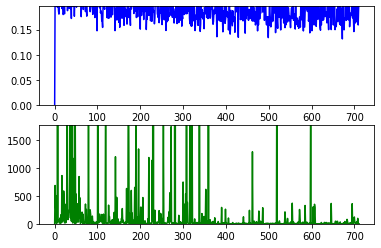

In [ ]:
for iteration in range(1000000):
    try:
        (coord, energy, f), (coord_rel, energy_rel, f_rel) = next(loader)
    except StopIteration:
        loader = iter(dataloader)
        (coord, energy, f), (coord_rel, energy_rel, f_rel) = next(loader)
        
#     coord.requires_grad=True
#     coord.requires_grad=True
    coord.requires_grad_()
    num_atoms = coord.shape[-2]
    
    pred_cord = model(f.cuda().double(), coord.cuda().double(), torch.ones(f.shape[0], 75).bool().cuda())
    cord_loss = (F.mse_loss(pred_cord, coord_rel.cuda().double(), reduction='none') / np.sqrt(num_atoms)).mean()
#     mse_en = F.mse_loss(preds.sum(-1), energy.cuda())
#     l1 = l1(preds, energies_t)
    pred_forces = - auto.grad(pred_cord.sum(), coord, retain_graph=True,
                       create_graph=True)[0]
    mse_f = (F.mse_loss(pred_forces[..., :3].cuda().double(), f_rel.cuda().double(), reduction='none').sum(dim=(1, 2)) / num_atoms).mean()
 
    loss = cord_loss +  (force_coefficient * mse_f) #
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
#     losses_en.append(mse_en.item())
    losses_f.append(mse_f.item())
    losses_coord.append(cord_loss.item())

    if iteration % 10 == 0:
        fig, ax = plt.subplots(2,1)

        clear_output(wait=True)

#         plt.plot(losses_en, 'r')
#         if len(losses_coord) <= 50:
#             plt.plot(losses_coord, 'b')
#             plt.plot(losses_f, 'g')

#             plt.show()
#         else:
        ax[0].plot(losses_coord, 'b', label='Coord loss')
        ax[0].set_ylim(0, np.mean(losses_coord[-100:]))
        ax[1].plot(losses_f, 'g', label='Force loss')
        ax[1].set_ylim(0, np.mean(losses_f[-1000:]))


        plt.show()

        
        
    if iteration % 100 == 0:
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                   }, f'checkpoints/checkpoint__deg4_{iteration}.pth')

    
    print(f"{iteration}   loss: {loss.cpu().detach().item():.3f} Energy RMSE: {np.sqrt(losses_en[-1]):.3f} eV \
        Force RMSE: {np.sqrt(losses_f[-1]):.3f} eV", end='\r')


In [43]:
dataset_test = Dataset(data, train=False)
dataloader_test = DataLoader(dataset_test, batch_size=120,
                        shuffle=False, num_workers=0)


In [52]:
model_ = model.cpu()

In [53]:
(cord, en, f), (cord_rel, en_rel, f_rel) = next(iter(dataloader_test))
out = model_(f, cord, torch.ones(88, 75).bool())


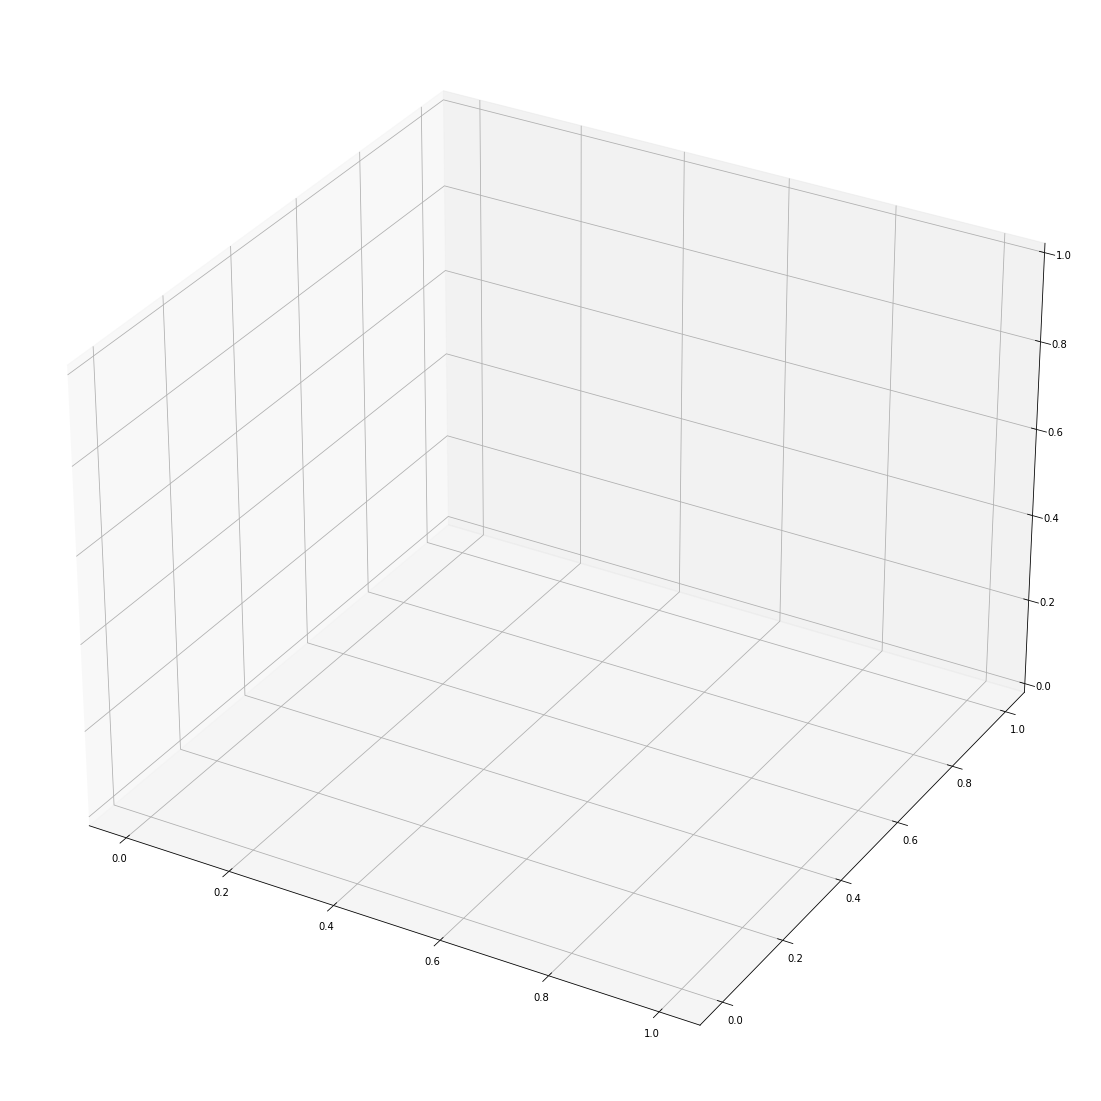

In [54]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*out[0].detach().numpy().T)

In [ ]:
for i in range(88):
    plt.plot(en.numpy()[i], out.cpu().detach().numpy()[i], '.')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coord.cpu().detach()[0,..., 0], coord.cpu().detach()[0,..., 1], coord.cpu().detach()[0,..., 2])
